## Загрузим нужные библиотеки

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from google.colab import drive
import numpy as np
import catboost as cb
from catboost.utils import eval_metric

%matplotlib inline

In [3]:
drive.mount('/content/drive')
SEED=100
WORK_DIR = '/content/drive/MyDrive/COMMON/karelia'
INIT_FLAG=0

Mounted at /content/drive


In [4]:
#!wget https://lodmedia.hb.bizmrg.com/case_files/822812/train_dataset_train.csv
#!wget https://lodmedia.hb.bizmrg.com/cases/822812/%D0%9A%D0%B0%D1%80%D0%B5%D0%BB%D0%B8%D1%8F.zip
#!mv karelia /content/drive/MyDrive/COMMON

In [5]:
#!unzip -q -d karelia Карелия.zip
!ls {WORK_DIR}

log.csv		     train_dataset_train.csv
named.csv	     type_contract.csv
sample_solution.csv  Республика_Карелия_условие_задачи.pdf
submits		     Ситилинк_baseline.ipynb


In [6]:
%%time
df_train = pd.read_csv(WORK_DIR+"/train_dataset_train.csv")
df_test = pd.read_csv(WORK_DIR+"/sample_solution.csv")

df_named = pd.read_csv(WORK_DIR+"/named.csv", parse_dates=['date'])
df_type_contract = pd.read_csv(WORK_DIR+"/type_contract.csv")
df_log = pd.read_csv(WORK_DIR+"/log.csv", parse_dates=['event_date'])


CPU times: user 5.44 s, sys: 634 ms, total: 6.08 s
Wall time: 11.1 s


In [7]:
TR_T_LIM =  len(df_train)
print(TR_T_LIM, len(df_test))
df = pd.concat([df_train, df_test])
df

5992 810


,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0
...,...,...
805,4258,0
806,4259,0
807,4260,0
808,4261,0


## Рассмотрим датасет по ближе

In [8]:
print(df.contract_id.nunique())
print(df.blocked.value_counts())
display(df.describe())
df

6802
0    6104
1     698
Name: blocked, dtype: int64


,contract_id,blocked
count,6802.000000,6802.000000
mean,43507.596001,0.102617
std,48611.293835,0.303480
min,3453.000000,0.000000
25%,11476.250000,0.000000
50%,38510.500000,0.000000
75%,50497.250000,0.000000
max,274918.000000,1.000000


,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0
...,...,...
805,4258,0
806,4259,0
807,4260,0
808,4261,0


In [9]:
df_named = df_named[df_named['contract_id'].isin(df['contract_id'])]
print(df_named.date.min())
print(df_named.date.max())
print(df_named['url'].nunique())
df_named.info()
df_named

2021-03-26 00:00:00
2021-04-30 00:00:00
542
<class 'pandas.core.frame.DataFrame'>
Int64Index: 145903 entries, 61 to 10646231
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         145903 non-null  datetime64[ns]
 1   url          145903 non-null  object        
 2   contract_id  145903 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.5+ MB


,date,url,contract_id
61,2021-04-17,moigorod.sampo.ru,27891
62,2021-04-17,moigorod.sampo.ru,27891
63,2021-04-17,profile.sampo.ru,27891
64,2021-04-17,profile.sampo.ru,27891
65,2021-04-17,ohrana.sampo.ru,27891
...,...,...,...
10645464,2021-03-31,sz-mrsk-itv01.svc.iptv.rt.ru,31215
10645836,2021-03-31,numbers.cloudpbx.rt.ru,49479
10646087,2021-03-31,petrozavodsk.speedtest.rt.ru,14456
10646100,2021-03-31,petrozavodsk.speedtest.rt.ru,46919


In [10]:
#df_type_contract
df_type_contract = df_type_contract[df_type_contract['contract_id'].isin(df['contract_id'])]
df_type_contract
#df_type_contract.groupby('contract_id').count()>1

,contract_id,day_or_month_contract
0,7780,0
1,3996,0
2,7785,0
3,7794,0
4,7795,1
...,...,...
6800,3503,1
6801,3589,0
6802,4261,0
6803,4118,1


In [11]:
df_log = df_log[df_log['contract_id'].isin(df['contract_id'])]
df_log['event_type']=df_log['event_type'].astype('category')
print(df_log['event_type'].nunique())
print(df_log['contract_id'].nunique())
display(df_log)
df_log_merged = df_log.groupby(['contract_id','event_type']).count()
display(df_log_merged)
'''
df_log_merged = pd.merge(df_log_merged, df_train, how='left', on='contract_id')
print(df_log_merged['blocked'].value_counts())
display(df_log_merged[df_log_merged['blocked']==1]['event_type'].describe())
display(df_log_merged[df_log_merged['blocked']==0]['event_type'].describe())
df_log_merged
#pd.merge(df_log, df_train, on)
'''

105
4311


,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах
...,...,...,...
25269,11801,2021-04-29 07:50:44,Информер ВК. Показ
25270,54405,2021-03-17 10:38:42,Информер ВК. Показ
25271,54405,2021-03-23 08:21:29,Информер ВК. Показ
25272,54405,2021-04-09 13:04:26,Информер ВК. Показ


event_date
contract_id event_type                                                    
3453        Абонент оставил отзыв в Личном кабинете                      0
            Активация ГП с IVR                                           0
            Активация автоматического гарантированного платежа           0
            Активация гарантированного платежа                           0
            Активация точки подключения на сутки                         0
...                                                                    ...
274918      Удаление ip-адреса                                           0
            Удаление из Обращались с номеров                             0
            Удаление телефона из записи                                  0
            Футболка Ситилинк                                            0
            Чек лист выполненных работ при регистрации                   0

[452655 rows x 1 columns]

"\ndf_log_merged = pd.merge(df_log_merged, df_train, how='left', on='contract_id')\nprint(df_log_merged['blocked'].value_counts())\ndisplay(df_log_merged[df_log_merged['blocked']==1]['event_type'].describe())\ndisplay(df_log_merged[df_log_merged['blocked']==0]['event_type'].describe())\ndf_log_merged\n#pd.merge(df_log, df_train, on)\n"

In [12]:

df_log_merged.reset_index()
display(df_log_merged[df_log_merged['event_date']>0])
df_log_pivoted = pd.pivot_table(df_log_merged, index=["contract_id"],columns=["event_type"])
df_log_pivoted#['Обращение в службу заботы о клиентах']

event_date
contract_id event_type                                       
3453        Информер ВК. Показ                              1
3454        Внутреннее сообщение                            1
3456        Внутреннее сообщение                            1
            Оборудование                                    1
            Смена тарифа                                    1
...                                                       ...
274786      Включение интернета на 20 минут с IVR           1
            Информер ВК. Показ                              2
            Обращение в службу заботы о клиентах            5
            Реестр договоров                                1
274918      Реестр договоров                                1

[11601 rows x 1 columns]

event_date                     \
event_type  Абонент оставил отзыв в Личном кабинете Активация ГП с IVR   
contract_id                                                              
3453                                              0                  0   
3454                                              0                  0   
3456                                              0                  0   
3457                                              0                  0   
3458                                              0                  0   
...                                             ...                ...   
274601                                            0                  0   
274710                                            0                  0   
274782                                            0                  0   
274786                                            0                  0   
274918                                            0                  0   

                                                                \
event_type  Активация автоматического гарантированного платежа   
contract_id                                                      
3453                                                         0   
3454                                                         0   
3456                                                         0   
3457                                                         0   
3458                                                         0   
...                                                        ...   
274601                                                       0   
274710                                                       0   
274782                                                       0   
274786                                                       0   
274918                                                       0   

                                                \
event_type  Активация гарантированного платежа   
contract_id                                      
3453                                         0   
3454                                         0   
3456                                         0   
3457                                         0   
3458                                         0   
...                                        ...   
274601                                       0   
274710                                       0   
274782                                       0   
274786                                       0   
274918                                       0   

                                                  \
event_type  Активация точки подключения на сутки   
contract_id                                        
3453                                           0   
3454                                           0   
3456                                           0   
3457                                           0   
3458                                           0   
...                                          ...   
274601                                         0   
274710                                         0   
274782                                         0   
274786                                         0   
274918                                         0   

                                                                              \
event_type  Без границ бесплатно. Включение Без границ бесплатно. Отключение   
contract_id                                                                    
3453                                      0                                0   
3454                                      0                                0   
3456                                      0                                0   
3457                                      0                                0   
3458                                      0                                0   
...      

In [13]:
#Абонент оставил отзыв в Личном кабинете
df_log_pivoted['event_date','Обращение в службу заботы о клиентах']

contract_id
3453      0
3454      0
3456      0
3457      0
3458      0
         ..
274601    2
274710    0
274782    4
274786    5
274918    0
Name: (event_date, Обращение в службу заботы о клиентах), Length: 4311, dtype: int64

In [14]:
df_big = pd.merge(df, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id")
df_big['day_or_month_contract'].fillna(1, inplace=True)
df_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6802 entries, 0 to 6806
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   contract_id            6802 non-null   int64  
 1   blocked                6802 non-null   int64  
 2   day_or_month_contract  6802 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 212.6 KB


In [15]:
old_cols=df_big.columns #['contract_id', 'blocked', 'day_or_month_contract']
df_big = pd.merge(df, df_log_pivoted , on="contract_id", how='left')
df_big.fillna(0,inplace=True)
df_big

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  


,contract_id,blocked,"(event_date, Абонент оставил отзыв в Личном кабинете)","(event_date, Активация ГП с IVR)","(event_date, Активация автоматического гарантированного платежа)","(event_date, Активация гарантированного платежа)","(event_date, Активация точки подключения на сутки)","(event_date, Без границ бесплатно. Включение)","(event_date, Без границ бесплатно. Отключение)","(event_date, Без границ платно. Включение)",...,"(event_date, Турбокнопка платно (1 сутки))","(event_date, Турбокнопка платно (1 час))","(event_date, Уведомления: отключение)","(event_date, Уведомления: подключение)","(event_date, Уведомления: подтверждение)","(event_date, Удаление ip-адреса)","(event_date, Удаление из Обращались с номеров)","(event_date, Удаление телефона из записи)","(event_date, Футболка Ситилинк)","(event_date, Чек лист выполненных работ при регистрации)"
0,7780,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7785,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7794,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7795,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7798,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6798,4259,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6799,4260,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6800,4261,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_big.reset_index()

,index,contract_id,blocked,"(event_date, Абонент оставил отзыв в Личном кабинете)","(event_date, Активация ГП с IVR)","(event_date, Активация автоматического гарантированного платежа)","(event_date, Активация гарантированного платежа)","(event_date, Активация точки подключения на сутки)","(event_date, Без границ бесплатно. Включение)","(event_date, Без границ бесплатно. Отключение)",...,"(event_date, Турбокнопка платно (1 сутки))","(event_date, Турбокнопка платно (1 час))","(event_date, Уведомления: отключение)","(event_date, Уведомления: подключение)","(event_date, Уведомления: подтверждение)","(event_date, Удаление ip-адреса)","(event_date, Удаление из Обращались с номеров)","(event_date, Удаление телефона из записи)","(event_date, Футболка Ситилинк)","(event_date, Чек лист выполненных работ при регистрации)"
0,0,7780,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7785,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,7794,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,7795,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,7798,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,6797,4258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6798,6798,4259,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6799,6799,4260,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6800,6800,4261,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
new_cols = [i[1] for i in df_big.columns[2:]]
#df_big.rename(columns=[list(df_big.columns[:2])+new_cols],axis=1)
df_big.rename(columns=dict(zip(df_big.columns, list(df_big.columns[:2])+new_cols)),inplace=True)
df_big

,contract_id,blocked,Абонент оставил отзыв в Личном кабинете,Активация ГП с IVR,Активация автоматического гарантированного платежа,Активация гарантированного платежа,Активация точки подключения на сутки,Без границ бесплатно. Включение,Без границ бесплатно. Отключение,Без границ платно. Включение,...,Турбокнопка платно (1 сутки),Турбокнопка платно (1 час),Уведомления: отключение,Уведомления: подключение,Уведомления: подтверждение,Удаление ip-адреса,Удаление из Обращались с номеров,Удаление телефона из записи,Футболка Ситилинк,Чек лист выполненных работ при регистрации
0,7780,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7785,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7794,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7795,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7798,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6798,4259,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6799,4260,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6800,4261,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:

from sklearn.linear_model import LogisticRegression

features=df_big.columns[2:]

X = df_big#.drop(["contract_id", "blocked"], axis = 1)
y = df_big[:TR_T_LIM]["blocked"]

X_train, X_val, y_train, y_val = train_test_split(X[:TR_T_LIM], y, test_size=0.15, random_state=SEED)
X_test = X[TR_T_LIM:]
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape)
'''
clf = LogisticRegression(random_state=SEED, max_iter=5000)

clf.fit(X_train, y_train)

pred = clf.predict(X_val)

print("Recall score:", recall_score(y_val, pred, average='macro'))
'''


features=df_big.columns[2:]

tree_params = {
    'iterations': 65000,
    'max_depth': 5,
    'early_stopping_rounds':100,
    'eval_metric': 'Recall',
    'loss_function': 'Logloss',
     'random_state': SEED,
    'l2_leaf_reg': 1,
    #'task_type': 'GPU' # если имеется GPU с CUDA, то можно ее задействовать, чтобы на порядок ускорить обучение
}


(5093, 107) (899, 107) (810, 107)
(5093,) (899,)


In [82]:
#features = features_vals[:30]
if INIT_FLAG==1:
    train_dataset = cb.Pool(data=X_train[features],
                        label=y_train,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )

    eval_dataset = cb.Pool(data=X_val[features],
                        label=y_val,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )

    test_dataset = cb.Pool(data=X_test[features],
                        #label=train_label,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )
    '''
    model = cb.CatBoostClassifier(**tree_params)    


    # Fit model
    model.fit(train_dataset)
    # Get predicted classes
    preds_class = model.predict(eval_dataset)
    # Get predicted probabilities for each class
    #preds_proba = model.predict_proba(eval_dataset)
    # Get predicted RawFormulaVal
    #preds_raw = model.predict(eval_dataset,
                            #prediction_type='RawFormulaVal')

    recall = round(recall_score(y_val, preds_class, average='macro'),4)
    print("Recall score:", recall)

    trhd = .5
    preds_class = model.predict_proba(test_dataset)[:,1]
    df_test['blocked']=list(preds_class)
    df_test['blocked'] = df_test['blocked'].apply(lambda x: 1 if x>trhd else 0)
    total=df_test['blocked'].sum()
    print(total)
    df_test.to_csv('kar_'+str(trhd)+'_'+str(tree_params['iterations'])+'_'+
        str(recall)+'_tot_'+str(total)+'_f_'+str(len(features))+'.csv', index=False)

    '''

Выходные данные были обрезаны до нескольких последних строк (5000).
60002:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60003:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60004:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60005:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60006:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60007:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60008:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60009:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60010:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60011:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60012:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60013:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60014:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60015:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60016:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60017:	learn: 0.4180887	total: 2m 34s	remaining: 12.8s
60018:	learn: 0.4180887	total: 2m 34s	remaining: 12.

In [83]:
trhd = .21
preds_class = model.predict_proba(test_dataset)[:,1]
df_test['blocked']=list(preds_class)
df_test['blocked'] = df_test['blocked'].apply(lambda x: 1 if x>trhd else 0)
total=df_test['blocked'].sum()
print(total)
df_test.to_csv('kar_'+str(trhd)+'_'+str(tree_params['iterations'])+'_'+
    str(recall)+'_tot_'+str(total)+'_f_'+str(len(features))+'.csv', index=False)
#features_vals = [list(X_train.columns)[i] for i in model.feature_importances_.argsort()[::-1]]

111


In [112]:
#dir(model)
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 7.6 MB/s 


In [73]:
 sum(X_val.iloc[4,:]- X_val.iloc[0,:])
 y_val.iloc[4], y_val.iloc[0], X_val.iloc[4,0], X_val.iloc[0,0]
 # (1, 0, 151336, 47030)
 # 151336, 47030 одинаковые контракты по логу обращений но разные по результату

(1, 0, 151336, 47030)

In [76]:
df_big.iloc[4,:]

contract_id                                           151336.0
blocked                                                    1.0
Абонент оставил отзыв в Личном кабинете                    0.0
Активация ГП с IVR                                         0.0
Активация автоматического гарантированного платежа         0.0
                                                        ...   
Удаление ip-адреса                                         0.0
Удаление из Обращались с номеров                           0.0
Удаление телефона из записи                                0.0
Футболка Ситилинк                                          0.0
Чек лист выполненных работ при регистрации                 0.0
Name: 5628, Length: 107, dtype: float64

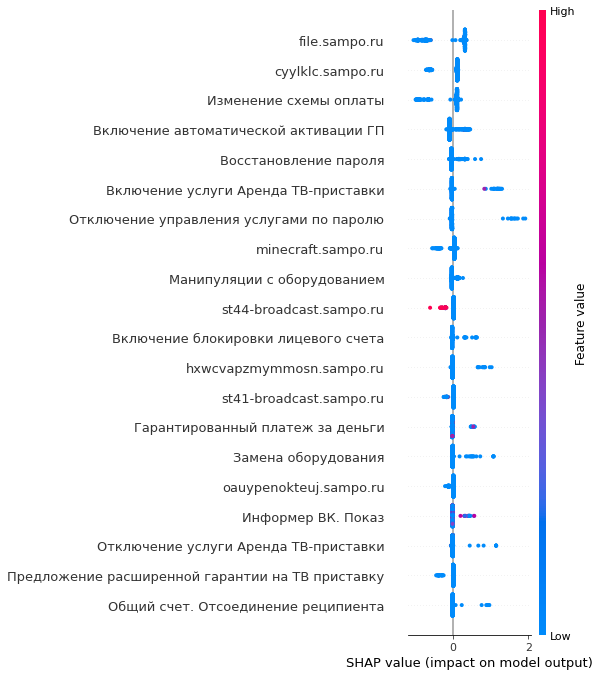

In [113]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val)

In [114]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[4,:], X_val.iloc[4,:])

In [52]:
#features = features_vals[:30]
features=df_big.columns[2:]
n_splits = 10

test_dataset = cb.Pool(data=X_test[features],
                    #label=train_label,
                    #cat_features=cat_cols,
                    #text_features = text_cols
                    )

cv = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)

model_list = []
recall_list = []
#X_train, X_val, y_train, y_val = train_test_split(X[:TR_T_LIM], y, test_size=0.15, random_state=SEED)
merged_data=X[:TR_T_LIM]
oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, y), 1):
    print(f'Training with fold {fold_} started.')
    model = cb.CatBoostClassifier(**tree_params)    
    
    X_train, X_val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_dataset = cb.Pool(data=X_train[features],
                        label=y_train,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )

    eval_dataset = cb.Pool(data=X_val[features],
                        label=y_val,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )
    
    model.fit(train_dataset, eval_set=[eval_dataset], early_stopping_rounds=100, verbose_eval=50, use_best_model=True, plot=False)
    model_list.append(model)

    oof[val_idx] = model.predict_proba(eval_dataset)[:, 1]
    val_pred_class = model.predict(eval_dataset)
    
    recall = round(recall_score(y_val, val_pred_class, average='macro'),4)
    print("Recall score:", recall)
    recall_list.append(recall)

    #break
    #recall = eval_metric(val_predict, y_val, 'Recall')[0]
    #print(f'reacll: {recall}')
print(recall_list)
recall = sum(recall_list)/len(recall_list)
print("Mean recall score:", recall)

Training with fold 1 started.
0:	learn: 0.0048154	test: 0.0000000	best: 0.0000000 (0)	total: 3.77ms	remaining: 4m 5s
50:	learn: 0.0321027	test: 0.0266667	best: 0.0266667 (40)	total: 158ms	remaining: 3m 21s
100:	learn: 0.0593900	test: 0.0533333	best: 0.0533333 (95)	total: 301ms	remaining: 3m 13s
150:	learn: 0.0979133	test: 0.1066667	best: 0.1066667 (150)	total: 451ms	remaining: 3m 13s
200:	learn: 0.1171750	test: 0.1333333	best: 0.1466667 (158)	total: 589ms	remaining: 3m 10s
250:	learn: 0.1396469	test: 0.1333333	best: 0.1466667 (158)	total: 735ms	remaining: 3m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1466666667
bestIteration = 158

Shrink model to first 159 iterations.
Recall score: 0.5714
Training with fold 2 started.
0:	learn: 0.0111288	test: 0.0000000	best: 0.0000000 (0)	total: 3.39ms	remaining: 3m 40s
50:	learn: 0.0349762	test: 0.0144928	best: 0.0144928 (35)	total: 146ms	remaining: 3m 5s
100:	learn: 0.0906200	test: 0.0579710	best: 0.0579710 (78)	total: 

In [55]:
score=np.zeros(test_dataset.shape[0])
for model in model_list:
    test_preds_proba = model.predict_proba(test_dataset)[:,1]
    print(test_preds_proba[0])
    score+=test_preds_proba
score=score/len(model_list)
print(score[0])
trhd = .305
preds_class = score
df_test['blocked']=list(preds_class)
df_test['blocked'] = df_test['blocked'].apply(lambda x: 1 if x>trhd else 0)
total=df_test['blocked'].sum()
print(total)
df_test.to_csv(WORK_DIR+'/submits/'+'kar_'+str(trhd)+'_'+
            str(tree_params['iterations'])+'_'+
            str(recall)+'_tot_'+str(total)+'_f_'+str(len(features))+
            '_spl_'+str(n_splits)+'.csv', index=False)


0.08911460048184017
0.07329925433674186
0.4840525440623965
0.09957690312007442
0.4836473574965803
0.48373376700827964
0.4839775676570138
0.09314187355656316
0.10051522884695384
0.4841181716184408
0.2875177268184884
147


In [70]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)

{0: 0.5655411073825504, 1: 4.3144}


In [18]:
tree_params = {
    #'iterations': 65000,
    #'auto_class_weights': True,
    #'class_weights':class_weights,
    'class_weights': {0: 1, 1: 5},
    'max_depth': 5,
    'early_stopping_rounds':100,
    'eval_metric': 'Recall',
    'loss_function': 'Logloss',
     'random_state': SEED,
    'l2_leaf_reg': 1,
    #'task_type': 'GPU' # если имеется GPU с CUDA, то можно ее задействовать, чтобы на порядок ускорить обучение
}

#features = features_vals[:30]
features=df_big.columns[2:]
n_splits = 10

test_dataset = cb.Pool(data=X_test[features],
                    #label=train_label,
                    #cat_features=cat_cols,
                    #text_features = text_cols
                    )

cv = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)

model_list = []
recall_list = []
#X_train, X_val, y_train, y_val = train_test_split(X[:TR_T_LIM], y, test_size=0.15, random_state=SEED)
merged_data=X[:TR_T_LIM]
oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, y), 1):
    print(f'Training with fold {fold_} started.')
    model = cb.CatBoostClassifier(**tree_params)    
    
    X_train, X_val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_dataset = cb.Pool(data=X_train[features],
                        label=y_train,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )

    eval_dataset = cb.Pool(data=X_val[features],
                        label=y_val,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )
    
    model.fit(train_dataset, eval_set=[eval_dataset], early_stopping_rounds=100, verbose_eval=50, use_best_model=True, plot=False)
    model_list.append(model)

    oof[val_idx] = model.predict_proba(eval_dataset)[:, 1]
    val_pred_class = model.predict(eval_dataset)
    
    recall = round(recall_score(y_val, val_pred_class, average='macro'),4)
    print("Recall score:", recall)
    recall_list.append(recall)

    #break
    #recall = eval_metric(val_predict, y_val, 'Recall')[0]
    #print(f'reacll: {recall}')
print(recall_list)
recall = sum(recall_list)/len(recall_list)
print("Mean recall score:", recall)

NameError: ignored

In [91]:
score=np.zeros(test_dataset.shape[0])
for model in model_list:
    test_preds_proba = model.predict_proba(test_dataset)[:,1]
    print(test_preds_proba[0])
    score+=test_preds_proba
score=score/len(model_list)
print(score[0])
trhd = .495
preds_class = score
df_test['blocked']=list(preds_class)
df_test['blocked'] = df_test['blocked'].apply(lambda x: 1 if x>trhd else 0)
total=df_test['blocked'].sum()
print(total)
df_test.to_csv(WORK_DIR+'/submits/'+'kar_'+str(trhd)+'_cw_h_5_'+
            #str(tree_params['iterations'])+'_'+
            str(recall)+'_tot_'+str(total)+'_f_'+str(len(features))+
            '_spl_'+str(n_splits)+'.csv', index=False)


0.3243748511863099
0.32619400082807837
0.2884344200072052
0.4953790626085101
0.4908062852657021
0.4951750399987993
0.2954757953766353
0.3300872215024854
0.3170965598778205
0.3102620194553397
0.36732852561068857
96


In [126]:
df_named = pd.read_csv(WORK_DIR+"/named.csv", parse_dates=['date'])
print(len(df_named))
df_named = df_named[df_named['contract_id'].isin(df['contract_id'])]
df_named

10646537


,date,url,contract_id
61,2021-04-17,moigorod.sampo.ru,27891
62,2021-04-17,moigorod.sampo.ru,27891
63,2021-04-17,profile.sampo.ru,27891
64,2021-04-17,profile.sampo.ru,27891
65,2021-04-17,ohrana.sampo.ru,27891
...,...,...,...
10645464,2021-03-31,sz-mrsk-itv01.svc.iptv.rt.ru,31215
10645836,2021-03-31,numbers.cloudpbx.rt.ru,49479
10646087,2021-03-31,petrozavodsk.speedtest.rt.ru,14456
10646100,2021-03-31,petrozavodsk.speedtest.rt.ru,46919


In [151]:
df_big

,contract_id,blocked,Абонент оставил отзыв в Личном кабинете,Активация ГП с IVR,Активация автоматического гарантированного платежа,Активация гарантированного платежа,Активация точки подключения на сутки,Без границ бесплатно. Включение,Без границ бесплатно. Отключение,Без границ платно. Включение,...,yaroslavl.speedtest.rt.ru.prod.hosts.ooklaserver.net,yfougrlfjrxahso.sampo.ru,yqksajnzjw.sampo.ru,yyzfdfhvvhizva.sampo.ru,zcsctotn.sampo.ru,zebra.sampo.ru,zhsgknv.sampo.ru,zjjfzmrknfejv.sampo.ru,zkkfeapz.sampo.ru,zpouueb.sampo.ru
0,7780,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7785,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7794,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7795,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7798,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6798,4259,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6799,4260,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6800,4261,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_named.info()
df_named['url'] = df_named['url'].astype('category')
df_named_gr  = df_named.groupby(['contract_id','url']).count()
#df_named_gr
df_named_gr.reset_index()
display(df_named_gr[df_named_gr['date']>0])
df_named_pivoted = pd.pivot_table(df_named_gr, index=["contract_id"],columns=["url"])
display(df_named_pivoted[('date','cnt-lbrc-itv01.svc.iptv.rt.ru')])

new_cols = [i[1] for i in df_named_pivoted.columns]
old_col_n = len(df_big.columns)
df_big = pd.merge(df_big, df_named_pivoted , on="contract_id", how='left')
df_big.rename(columns=dict(zip(list(df_big.columns[old_col_n:]), new_cols)),inplace=True)
df_big[new_cols] = df_big[new_cols].fillna(0)
df_big

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145903 entries, 61 to 10646231
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         145903 non-null  datetime64[ns]
 1   url          145903 non-null  object        
 2   contract_id  145903 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.5+ MB


date
contract_id url                                                     
3455        cnt-lbrc-itv01.svc.iptv.rt.ru                          2
            cnt-odcv-itv02.svc.iptv.rt.ru                          1
            cnt-odcv-itv03.svc.iptv.rt.ru                          1
            data.sampo.ru                                          5
            go.sampo.ru                                            3
...                                                              ...
273538      fnc.rt.ru                                              2
            petrozavodsk.speedtest.rt.ru.prod.hosts.ooklase...     1
            speedtest.sampo.ru.prod.hosts.ooklaserver.net          1
            st.sampo.ru                                            1
274786      fnc.rt.ru                                              1

[19929 rows x 1 columns]

contract_id
3455      2
3458      0
3459      0
3460      0
3461      0
         ..
271820    0
272061    0
273472    0
273538    0
274786    0
Name: (date, cnt-lbrc-itv01.svc.iptv.rt.ru), Length: 3305, dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  if sys.path[0] == '':


,contract_id,blocked,Абонент оставил отзыв в Личном кабинете,Активация ГП с IVR,Активация автоматического гарантированного платежа,Активация гарантированного платежа,Активация точки подключения на сутки,Без границ бесплатно. Включение,Без границ бесплатно. Отключение,Без границ платно. Включение,...,yaroslavl.speedtest.rt.ru.prod.hosts.ooklaserver.net,yfougrlfjrxahso.sampo.ru,yqksajnzjw.sampo.ru,yyzfdfhvvhizva.sampo.ru,zcsctotn.sampo.ru,zebra.sampo.ru,zhsgknv.sampo.ru,zjjfzmrknfejv.sampo.ru,zkkfeapz.sampo.ru,zpouueb.sampo.ru
0,7780,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7785,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7794,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7795,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7798,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,4258,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6798,4259,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6799,4260,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6800,4261,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X = df_big
y = df_big[:TR_T_LIM]["blocked"]

X_train, X_val, y_train, y_val = train_test_split(X[:TR_T_LIM], y, test_size=0.15, random_state=SEED)
X_test = X[TR_T_LIM:]
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape)

features=df_big.columns[2:]

(5093, 649) (899, 649) (810, 649)
(5093,) (899,)


In [122]:
from sklearn.linear_model import LogisticRegression

#features = tmp_features
model_list = []
recall_list = []

merged_data=X[:TR_T_LIM]
#oof = np.zeros(len(merged_data))
#train_preds = np.zeros(len(merged_data))

n_splits = 10
cv = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, y), 1):
    print(f'Training with fold {fold_} started.')
    clf = LogisticRegression(C=1., random_state=SEED, max_iter=5000)
    
    X_train, X_val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    clf.fit(X_train[features], y_train)

    pred = clf.predict(X_val[features])
    recall = recall_score(y_val, pred, average='macro')
    print("Recall score:", recall)

    model_list.append(clf)
    recall_list.append(recall)
print(sum(recall_list)/len(recall_list))

Training with fold 1 started.
Recall score: 0.5561904761904762
Training with fold 2 started.
Recall score: 0.5337754851387866
Training with fold 3 started.
Recall score: 0.5557562620423893
Training with fold 4 started.
Recall score: 0.5344780303491986
Training with fold 5 started.
Recall score: 0.5663767127181761
Training with fold 6 started.
Recall score: 0.5648123143397246
Training with fold 7 started.
Recall score: 0.5301733687825413
Training with fold 8 started.
Recall score: 0.5474834474245315
Training with fold 9 started.
Recall score: 0.5775225594749795
Training with fold 10 started.
Recall score: 0.5374889317151935
0.5504057588175997


In [166]:
score=np.zeros(X_test.shape[0])
for model in model_list:
    test_preds_proba = model.predict_proba(X_test[features])[:,1]
    print(test_preds_proba[0])
    score+=test_preds_proba
score=score/len(model_list)
print(score[0])
trhd = .5

df_test_lr=df_test_best[['contract_id','blocked']].copy(deep=True)
df_test_lr['blocked_lr']=list(score)
#df_test_lr['blocked_class'] = df_test_lr['blocked'].apply(lambda x: 1 if x>trhd else 0)
total=sum(df_test_lr['blocked_lr']>trhd)
print(total)
'''
df_test.to_csv(WORK_DIR+'/submits/'+'kar_lr_cv'+str(trhd)+'_cw_h_5_'+
            #str(tree_params['iterations'])+'_'+
            str(recall)+'_tot_'+str(total)+'_f_'+str(len(features))+
            '_spl_'+str(n_splits)+'.csv', index=False)
'''
score_lr_10=score
df_test_lr

0.10739036424963368
0.11049550324671606
0.11638400576120696
0.48500041739774585
0.11865828895116183
0.11135013596251832
0.484941864997712
0.11603676130691372
0.11576273344518997
0.1194166815240488
0.1885436756842847
12


,contract_id,blocked,blocked_lr
0,3453,0,0.188544
1,3454,1,0.315455
2,3455,0,0.142872
3,3456,1,0.335190
4,3457,0,0.153851
...,...,...,...
805,4258,0,0.205666
806,4259,0,0.127290
807,4260,0,0.153302
808,4261,1,0.411016


In [165]:
trhd=.22
sum((df_test_lr['blocked_lr']>trhd).astype('int'))
#df_test_lr[(df_test_lr['blocked_lr']>trhd) & (df_test_lr['blocked']==0)]
print(sum(df_test_lr[df_test_lr['blocked_lr']>trhd]['blocked']))
df_test_lr[df_test_lr['blocked_lr']>trhd]

122


,contract_id,blocked,blocked_lr
1,3454,1,0.315455
3,3456,1,0.335190
10,3463,1,0.304783
12,3465,1,0.247354
13,3466,1,0.297491
...,...,...,...
782,4235,1,0.304783
787,4240,1,0.227426
794,4247,1,0.313798
801,4254,1,0.417525


In [65]:
trhd=.16
sum(score_cb>trhd)
blocked=score_cb>trhd
print(sum(blocked))
df_test['blocked_cb']=score_cb
df_test['blocked_cb'] = df_test['blocked_cb'].apply(lambda x: 1 if x>trhd else 0)

133


In [67]:
trhd=.5
sum(score_lr_10>trhd)
blocked=score_lr_10>trhd
print(sum(blocked))
df_test['blocked_lr']=score_lr_10
df_test['blocked_lr'] = df_test['blocked_lr'].apply(lambda x: 1 if x>trhd else 0)
df_test

20


,contract_id,blocked,blocked_cb,blocked_lr
0,3453,0,0,0
1,3454,1,1,0
2,3455,0,0,0
3,3456,1,1,0
4,3457,0,0,0
...,...,...,...,...
805,4258,1,0,0
806,4259,1,0,1
807,4260,0,0,0
808,4261,1,1,0


In [69]:
df_test['blocked'] = (df_test['blocked_cb']+df_test['blocked_lr']).apply(lambda x: 1 if x>0 else 0)
sum(df_test['blocked'])

134

In [38]:
trhd = .18
preds_class = score
df_test['blocked']=list(preds_class)
df_test['blocked'] = df_test['blocked'].apply(lambda x: 1 if x>trhd else 0)
total=df_test['blocked'].sum()
path = str(WORK_DIR+'/submits/'+'kar_'+str(trhd)+'_cw_h_2_'+
            #str(tree_params['iterations'])+'_'+\
            str(recall)+'_tot_'+str(total)#+'_f_'+str(len(features))+
            #'_md_'+str(tree_params['max_depth'])+
            #'_l2l_'+str(tree_params['l2_leaf_reg'])+#'_cw1_5_'+
            #'_spl_'+str(n_splits)
            +'.csv'
)
print(total, path)
df_test.to_csv(path, index=False)


98 /content/drive/MyDrive/COMMON/karelia/submits/kar_0.18_cw_h_2_0.5523348157560356_tot_98.csv


In [234]:
#block_features = df_big.columns[df_big[:TR_T_LIM][df_big[:TR_T_LIM]['blocked']==1].sum()>0][2:]
features=df_big.columns[2:]

#df_big[df_big['blocked']==1]][features]
features

Index(['Абонент оставил отзыв в Личном кабинете', 'Активация ГП с IVR',
       'Активация автоматического гарантированного платежа',
       'Активация гарантированного платежа',
       'Активация точки подключения на сутки',
       'Без границ бесплатно. Включение', 'Без границ бесплатно. Отключение',
       'Без границ платно. Включение', 'Без границ платно. Отключение',
       'Блокировка',
       ...
       'best_www.old.rt.ru', 'best_xigdqpyfoke.sampo.ru',
       'best_xnbgaku.sampo.ru', 'best_xohgbgdj.sampo.ru',
       'best_yfougrlfjrxahso.sampo.ru', 'best_yqksajnzjw.sampo.ru',
       'best_zcsctotn.sampo.ru', 'best_zhsgknv.sampo.ru',
       'best_zjjfzmrknfejv.sampo.ru', 'best_zkkfeapz.sampo.ru'],
      dtype='object', length=790)

In [237]:

tree_params = {
    #'iterations': 65000,
    'max_depth': 5,
    #'class_weights': {0: .9, 1: 2},
    'early_stopping_rounds': 100,
    'eval_metric': 'Recall',
    'loss_function': 'Logloss',
    'random_state': SEED,
    'l2_leaf_reg': 1,
    #'task_type': 'GPU' # если имеется GPU с CUDA, то можно ее задействовать, чтобы на порядок ускорить обучение
}



n_splits = 10

test_dataset = cb.Pool(data=X_test[features],
                    #label=train_label,
                    #cat_features=cat_cols,
                    #text_features = text_cols
                    )

cv = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)
#cv = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)

model_list = []
recall_list = []
#X_train, X_val, y_train, y_val = train_test_split(X[:TR_T_LIM], y, test_size=0.15, random_state=SEED)
merged_data=X[:TR_T_LIM]
oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, y), 1):
    print(f'Training with fold {fold_} started.')
    model = cb.CatBoostClassifier(**tree_params)    
    
    X_train, X_val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_dataset = cb.Pool(data=X_train[features],
                        label=y_train,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )

    eval_dataset = cb.Pool(data=X_val[features],
                        label=y_val,
                        #cat_features=cat_cols,
                        #text_features = text_cols
                        )
    
    #model.fit(train_dataset, eval_set=[eval_dataset], early_stopping_rounds=100, verbose_eval=50, use_best_model=True, plot=False)
    model.fit(train_dataset, eval_set=[eval_dataset], verbose_eval=50, use_best_model=True, plot=False)#
    model_list.append(model)

    oof[val_idx] = model.predict_proba(eval_dataset)[:, 1]
    val_pred_class = model.predict(eval_dataset)
    
    recall = round(recall_score(y_val, val_pred_class, average='macro'),4)
    print("Recall score:", recall)
    recall_list.append(recall)

    #break
    #recall = eval_metric(val_predict, y_val, 'Recall')[0]
    #print(f'reacll: {recall}')
print(recall_list)
recall = str((sum(recall_list)/len(recall_list)).round(5)).split('.')[-1]
print("Mean recall score:", recall)

score_cb=np.zeros(test_dataset.shape[0])
for model in model_list:
    test_preds_proba = model.predict_proba(test_dataset)[:,1]
    print(test_preds_proba[0])
    score_cb+=test_preds_proba
score_cb=score_cb/len(model_list)
print(score_cb[0])

Training with fold 1 started.
0:	learn: 0.0016051	test: 0.0000000	best: 0.0000000 (0)	total: 8.8ms	remaining: 8.79s
50:	learn: 0.0288925	test: 0.0266667	best: 0.0266667 (48)	total: 441ms	remaining: 8.21s
100:	learn: 0.0545746	test: 0.0800000	best: 0.0800000 (99)	total: 884ms	remaining: 7.87s
150:	learn: 0.0947030	test: 0.1200000	best: 0.1200000 (111)	total: 1.28s	remaining: 7.23s
200:	learn: 0.1091493	test: 0.1200000	best: 0.1200000 (111)	total: 2.35s	remaining: 9.33s
250:	learn: 0.1284109	test: 0.1600000	best: 0.1733333 (242)	total: 3.26s	remaining: 9.73s
300:	learn: 0.1476726	test: 0.1733333	best: 0.1733333 (242)	total: 4.66s	remaining: 10.8s
350:	learn: 0.1685393	test: 0.1866667	best: 0.1866667 (329)	total: 5.23s	remaining: 9.68s
400:	learn: 0.1958266	test: 0.2000000	best: 0.2000000 (365)	total: 5.64s	remaining: 8.42s
450:	learn: 0.2263242	test: 0.2000000	best: 0.2000000 (365)	total: 6.08s	remaining: 7.4s
500:	learn: 0.2391653	test: 0.2133333	best: 0.2133333 (462)	total: 6.5s	remain

In [243]:
df_test = df_big[TR_T_LIM:][list(df_big.columns[:2])]
df_test

,contract_id,blocked
5992,3453,0
5993,3454,0
5994,3455,0
5995,3456,0
5996,3457,0
...,...,...
6797,4258,0
6798,4259,0
6799,4260,0
6800,4261,0


In [250]:
score = score_cb
#score = (score_cb+score_lr)/2
#score = (score_cb+score_lr+score_rf)/3
trhd = .187
preds_class = score
df_test['blocked']=list(preds_class)
df_test['blocked'] = df_test['blocked'].apply(lambda x: 1 if x>trhd else 0)
total=df_test['blocked'].sum()
#path = str(WORK_DIR+'/submits/'+'kar_lr_cb_rf'+str(trhd)+'_cw_h_2_'+
path = str(WORK_DIR+'/submits/'+'kar_cb_'+str(trhd).split('.')[-1]+#'_cw_h_2_'+
            #str(tree_params['iterations'])+'_'+\
            '_'+str(recall)+'_tot_'+str(total)+'_f_'+str(len(features))+
            '_md_'+str(tree_params['max_depth'])+
            '_es_'+str(tree_params['early_stopping_rounds'])+
            '_l2l_'+str(tree_params['l2_leaf_reg'])+#'_cw1_5_'+
            '_spl_'+str(n_splits)+'.csv'
)
print(total, path)
df_test[['contract_id','blocked']].to_csv(path, index=False)
#df_test

119 /content/drive/MyDrive/COMMON/karelia/submits/kar_cb_187_55157_tot_119_f_790_md_5_es_100_l2l_1_spl_10.csv


In [147]:
#df_test = df_test[['contract_id','blocked']].to_csv(WORK_DIR+'/submits/test_best.csv', index=False)
df_test_best = pd.read_csv(WORK_DIR+'/submits/test_best.csv')
df_test_best

,contract_id,blocked
0,3453,0
1,3454,1
2,3455,0
3,3456,1
4,3457,0
...,...,...
805,4258,0
806,4259,0
807,4260,0
808,4261,1


In [143]:
trhd=.5
#df_test_lr[df_test_lr['blocked_lr']>trhd]
sum(df_test_lr['blocked'])

119

In [32]:
best_features = model.feature_importances_.argsort()[::-1][:30]
tmp_features = features[best_features]

In [336]:
#df_big[new_cols].sum(axis=0)
bool_new_cols = ['bool_'+col for col in new_cols]
bool_new_cols
for col in new_cols:
    df_big['bool_'+col]=df_big[col].apply(lambda x: 0 if x==0 else 1)
df_big['bool_new_cols_sum'] = df_big[bool_new_cols].sum(axis=1)
bool_new_cols.append('bool_new_cols_sum')
print(len(features))
features = list(set(features)-set(new_cols))+bool_new_cols
print(len(features))

647
648


In [368]:
features = list(set(df_big.columns[2:])-set(new_cols))#+bool_new_cols
len(features)

649

In [355]:
df_big['bool_block_cols_sum'] = df_big[block_features].sum(axis=1)
bool_new_cols.append('bool_block_cols_sum')


TypeError: ignored

In [236]:
X = df_big
y = df_big[:TR_T_LIM]["blocked"]

X_train, X_val, y_train, y_val = train_test_split(X[:TR_T_LIM], y, test_size=0.15, random_state=SEED)
X_test = X[TR_T_LIM:]


In [391]:
X_tr_val = df_big[:TR_T_LIM]
blocked = X_tr_val['blocked']==1
X_tr_val[blocked].sum()
zero_not_blocked = X_tr_val.columns[X_tr_val[~blocked].sum()==0]
X_tr_val[blocked][zero_not_blocked].sum()

blocked                                698.0
Блокировка                               2.0
Блокировка лицевого счета                0.0
Включение блокировки лицевого счета      0.0
Добавление IP-адреса                     0.0
                                       ...  
bool_yqksajnzjw.sampo.ru                 1.0
bool_zcsctotn.sampo.ru                   1.0
bool_zhsgknv.sampo.ru                    1.0
bool_zjjfzmrknfejv.sampo.ru              1.0
bool_zkkfeapz.sampo.ru                   1.0
Length: 214, dtype: float64

Абонент оставил отзыв в Личном кабинете               61.0
Активация ГП с IVR                                    63.0
Активация автоматического гарантированного платежа     7.0
Активация гарантированного платежа                    66.0
Активация точки подключения на сутки                  38.0
                                                      ... 
zebra.sampo.ru                                         2.0
zhsgknv.sampo.ru                                       1.0
zjjfzmrknfejv.sampo.ru                                 1.0
zkkfeapz.sampo.ru                                      1.0
zpouueb.sampo.ru                                       2.0
Length: 647, dtype: float64

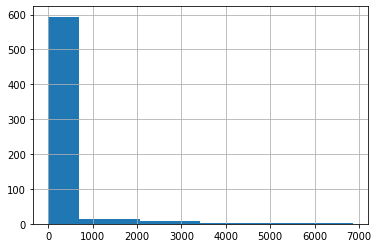

In [72]:
#df_tr_v=df_big[:TR_T_LIM]
#blocked = df_tr_v['blocked']>0
non_block_cols = df_tr_v[~blocked][features].sum()+1#.argsort()[::-1]
non_block_cols.hist()
non_block_cols

Абонент оставил отзыв в Личном кабинете               11.0
Активация ГП с IVR                                    10.0
Активация автоматического гарантированного платежа     3.0
Активация гарантированного платежа                    30.0
Активация точки подключения на сутки                  24.0
                                                      ... 
zebra.sampo.ru                                         1.0
zhsgknv.sampo.ru                                       2.0
zjjfzmrknfejv.sampo.ru                                 2.0
zkkfeapz.sampo.ru                                      2.0
zpouueb.sampo.ru                                       1.0
Length: 647, dtype: float64

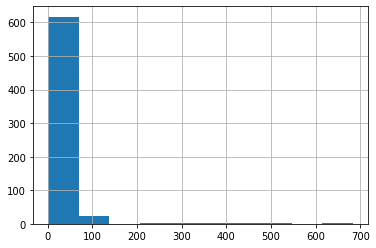

In [71]:
block_cols =df_tr_v[blocked][features].sum()+1#.argsort()[::-1]
block_cols.hist()
block_cols

In [227]:
for ind in list((block_cols/non_block_cols).index):
    print(ind)
    print((block_cols/non_block_cols).loc[ind])
    break

Абонент оставил отзыв в Личном кабинете
0.18032786885245902


In [231]:
trhd_new=.5

#print(len(df_tr_v[blocked])/len(df_tr_v[~blocked]))
#sum((block_cols/non_block_cols).sort_values(ascending=False)>trhd_new)#.head(35)#.argsort()[::-1]
new_new_cols=[]
new_old_cols=[]
for ind in list((block_cols/non_block_cols).index):
    if (block_cols/non_block_cols).loc[ind]>trhd_new:
        new_old_cols.append(ind)
        new_new_cols.append('best_'+ind)
new_new_cols[:10], len(new_old_cols), len(new_new_cols),

(['best_Активация точки подключения на сутки',
  'best_Блокировка',
  'best_Блокировка лицевого счета',
  'best_Виртуальное бессмертие. Включение',
  'best_Виртуальное бессмертие. Использование',
  'best_Виртуальное бессмертие. Отключение',
  'best_Включение Бесплатной аренды',
  'best_Включение блокировки лицевого счета',
  'best_Включение ограничения функций ТВ',
  'best_Внутреннее сообщение'],
 143,
 143)

In [233]:
for ind,col in enumerate(new_old_cols):
    #print(new_new_cols[ind])
    #print(new_old_cols[ind])
    df_big[new_new_cols[ind]] = df_big[new_old_cols[ind]]
    #break
len(df_big.columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


792

Узнаем размерность наборов

In [41]:
print("df_train", df_train.shape)
print("df_named", df_named.shape)
print("df_sample_solution", df_sample_solution.shape)
print("df_type_contract", df_type_contract.shape)
print("df_log", df_log.shape)

df_train (5992, 2)
df_named (10646537, 3)
df_sample_solution (810, 2)
df_type_contract (6805, 2)
df_log (25274, 3)


### Видоизмение данных

Обьединим два набора с данными

In [42]:
df_train = pd.merge(df_train, df_type_contract , on="contract_id", how='left').drop_duplicates(subset="contract_id")

df_train

,contract_id,blocked,day_or_month_contract
0,7780,0,0.0
1,7785,0,0.0
2,7794,0,0.0
3,7795,0,1.0
4,7798,0,0.0
...,...,...,...
5988,274601,1,1.0
5989,274710,1,0.0
5990,274782,1,0.0
5991,274786,1,1.0


Добавим столбец - колличество обращений человека

In [43]:
count_log = df_log.groupby("contract_id").count()

count_log#.head(3)

,event_date,event_type
contract_id,,
3453,1,1
3454,1,1
3456,4,4
3457,4,4
3458,23,23
...,...,...
274601,6,6
274710,7,7
274782,8,8


In [44]:
df_train = pd.merge(df_train, count_log , on="contract_id", how='left').drop(["event_type"],axis =1)
#df_train = pd.merge(df_train, count_log , on="contract_id", how='left')

In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 5991
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   contract_id            5992 non-null   int64  
 1   blocked                5992 non-null   int64  
 2   day_or_month_contract  5990 non-null   float64
 3   event_date             3809 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 234.1 KB


Заменим пропуски на нули

In [46]:
df_train = df_train.fillna(0)

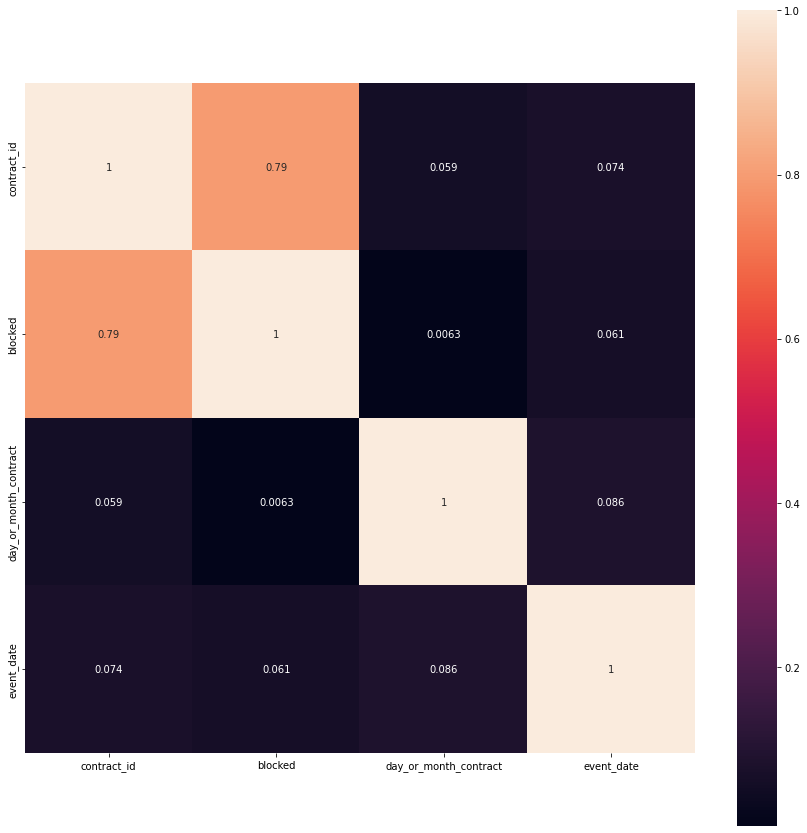

In [47]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

In [48]:
X = df_train.drop(["contract_id", "blocked"], axis = 1)
y = df_train[["blocked"]]

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 5991
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   day_or_month_contract  5992 non-null   float64
 1   event_date             5992 non-null   float64
dtypes: float64(2)
memory usage: 140.4 KB


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [167]:
'''
X = df_big
y = df_big[:TR_T_LIM]["blocked"]

X_train, X_val, y_train, y_val = train_test_split(X[:TR_T_LIM], y, test_size=0.15, random_state=SEED)
X_test = X[TR_T_LIM:]
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape)
'''

model_list = []
recall_list = []

merged_data=X[:TR_T_LIM]
#oof = np.zeros(len(merged_data))
#train_preds = np.zeros(len(merged_data))

n_splits = 10
cv = KFold(n_splits=n_splits, random_state=SEED, shuffle=True)


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, y), 1):
    print(f'Training with fold {fold_} started.')
    clf = RandomForestClassifier(random_state=SEED)
    
    X_train, X_val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    clf.fit(X_train[features], y_train)

    pred = clf.predict(X_val[features])
    recall = recall_score(y_val, pred, average='macro')
    print("Recall score:", recall)

    model_list.append(clf)
    recall_list.append(recall)
print(sum(recall_list)/len(recall_list))


score_rf = clf.predict_proba(X_test[features])[:,1]


Training with fold 1 started.
Recall score: 0.5952380952380952
Training with fold 2 started.
Recall score: 0.560222713502006
Training with fold 3 started.
Recall score: 0.5591160886319846
Training with fold 4 started.
Recall score: 0.5398866475714548
Training with fold 5 started.
Recall score: 0.569190971629996
Training with fold 6 started.
Recall score: 0.574372130704834
Training with fold 7 started.
Recall score: 0.5347014512019497
Training with fold 8 started.
Recall score: 0.5866765795084727
Training with fold 9 started.
Recall score: 0.6099808586272901
Training with fold 10 started.
Recall score: 0.5854341371946455
0.5714819673810728


In [170]:
score=np.zeros(X_test.shape[0])
for model in model_list:
    test_preds_proba = model.predict_proba(X_test[features])[:,1]
    print(test_preds_proba[0])
    score+=test_preds_proba
score=score/len(model_list)
print(score[0])
trhd = .5

df_test_rf=df_test_best[['contract_id','blocked']].copy(deep=True)
df_test_rf['blocked_rf']=list(score)
#df_test_lr['blocked_class'] = df_test_lr['blocked'].apply(lambda x: 1 if x>trhd else 0)
total=sum(df_test_rf['blocked_rf']>trhd)
print(total)
score_rf_10=score
df_test_rf

0.06291485491644545
0.04910133502697087
0.042115604123236346
0.052097116270614634
0.056282796502276806
0.05801511335197501
0.05126438533998214
0.06091410448704031
0.05093879301447455
0.06226151590364919
0.05459056189366653
28


,contract_id,blocked,blocked_rf
0,3453,0,0.054591
1,3454,1,0.188300
2,3455,0,0.074000
3,3456,1,0.293258
4,3457,0,0.028033
...,...,...,...
805,4258,0,0.000000
806,4259,0,0.120000
807,4260,0,0.003095
808,4261,1,0.381000


In [191]:
#rf_add_dict = dict()
trhd_rf=.41
sum((df_test_rf['blocked_rf']>trhd_rf).astype('int'))
print(sum(df_test_rf[df_test_rf['blocked_rf']>trhd_rf]['blocked']))
#df_test_rf[df_test_rf['blocked_rf']>trhd]
rf_add_dict[trhd_rf] = list(df_test_rf[(df_test_rf['blocked_rf']>trhd_rf) & (df_test_rf['blocked']==0)]['contract_id'])

39
0.5
0.45
0.41
0.35


In [203]:
for trhd_rf in sorted(rf_add_dict.keys())[::-1]:
    df_test_rf_tmp = df_test_rf.copy(deep=True)
    #df_test_rf_tmp['blocked']
    #print(rf_add_dict[trhd_rf])
    df_test_rf_tmp.loc[
        df_test_rf_tmp['contract_id'].isin(rf_add_dict[trhd_rf]),['blocked']]=1
    path = str(
            WORK_DIR+'/submits/'+'kar_rftr'+str(trhd_rf)+'_add_'+
               str(len(rf_add_dict[trhd_rf]))+
               '.csv'
               )
    print(path)
    df_test_rf_tmp[['contract_id','blocked']].to_csv(path, index=False)
    #break
display(df_test_rf_tmp.loc[df_test_rf_tmp['contract_id'].isin(rf_add_dict[trhd_rf])]
    )

/content/drive/MyDrive/COMMON/karelia/submits/kar_rftr0.5_add_6.csv
/content/drive/MyDrive/COMMON/karelia/submits/kar_rftr0.45_add_12.csv
/content/drive/MyDrive/COMMON/karelia/submits/kar_rftr0.41_add_14.csv
/content/drive/MyDrive/COMMON/karelia/submits/kar_rftr0.35_add_26.csv


,contract_id,blocked,blocked_rf
96,3549,1,0.473527
101,3554,1,0.408421
174,3627,1,0.556133
211,3664,1,0.602046
249,3702,1,0.353539
309,3762,1,0.472969
338,3791,1,0.440168
347,3800,1,0.380475
367,3820,1,0.460285
390,3843,1,0.372219
